In [1]:
import os
import csv
import cv2
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sampleLines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if line[3].find('steering') == -1:
            sampleLines.append(line)

In [2]:
training_samples, validation_samples = train_test_split(sampleLines, test_size=0.2)

print("{} Training Samples".format(len(training_samples)))
print("{} Validation Samples".format(len(validation_samples)))

12684 Training Samples
3172 Validation Samples


In [3]:
# A Generator to read in the data in partitions
def generator(samples, batch_size=32):
    num_samples = len(samples)
    
    while 1:
        samples = shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            correction = [0, 0.15, -0.15]
            for batch_sample in batch_samples:
                #All the cameras have a normal and flipped entry
                for camera in range(3):
                    name = 'data/IMG/'+batch_sample[camera].split('/')[-1]
                    bgr = cv2.imread(name)
                    rgb = bgr[...,::-1]
                    angle = float(batch_sample[3]) + correction[camera]
                    images.append(rgb)
                    angles.append(angle)

                    flipped_image = cv2.flip(rgb, 1)
                    flipped_angle = -angle
                    images.append(flipped_image)
                    angles.append(flipped_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [4]:
training_generator = generator(training_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

Epoch 1/3
76104/76104 [==============================] - 663s - loss: 0.0456 - val_loss: 0.0347
Epoch 2/3
76104/76104 [==============================] - 657s - loss: 0.0329 - val_loss: 0.0345
Epoch 3/3
76104/76104 [==============================] - 656s - loss: 0.0310 - val_loss: 0.0324
dict_keys(['loss', 'val_loss'])


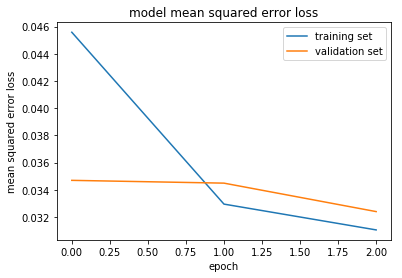

In [7]:
# Code for compiling and training the model
from keras.models import Model, Sequential
from keras.layers import Convolution2D, Cropping2D, Dense, Flatten
from keras.layers import Activation, Dropout, Input, Lambda, MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((60,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='elu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
model.add(Convolution2D(64,3,3,activation='elu'))
model.add(Convolution2D(64,3,3,activation='elu'))
model.add(Flatten())
model.add(Dropout(0.2, input_shape=(100,)))
model.add(Activation('elu'))
model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(training_generator, 
                    samples_per_epoch=6*len(training_samples), 
                    validation_data=validation_generator, 
                    nb_val_samples=6*len(validation_samples), 
                    nb_epoch=3)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model.h5')